In [1]:
from ler.rates import LeR
from ler.utils import get_param_from_json
import numpy as np
import matplotlib.pyplot as plt

# other necessary imports
from astropy.cosmology import LambdaCDM

Setting multiprocessing start method to 'fork'


In [2]:
# Complete setup for LeR

ler = LeR(
    # LeR setup arguments
    npool=8, # number of processors to use
    z_min=0.0, # minimum redshift
    z_max=10.0, # maximum redshift
    event_type='BBH', # event type
    size=100000, # number of events to simulate
    batch_size=50000, # batch size
    cosmology=LambdaCDM(H0=70, Om0=0.3, Ode0=0.7), # cosmology
    snr_finder=None, # snr calculator from 'gwsnr' package will be used
    pdet_finder=None,  # will not be consider unless specified
    list_of_detectors=None, # list of detectors that will be considered when calculating snr or pdet for lensed events. if None, all the detectors from 'gwsnr' will be considered
    json_file_names=dict(
        ler_params="ler_params.json", # to store initialization parameters and important results
        unlensed_param="unlensed_param.json", # to store all unlensed events
        unlensed_param_detectable="unlensed_param_detectable.json", # to store only detectable unlensed events
        lensed_param="lensed_param.json", # to store all lensed events 
        lensed_param_detectable="lensed_param_detectable.json"), # to store only detectable lensed events
    interpolator_directory='./interpolator_pickle', # directory to store the interpolator pickle files. 'ler' uses interpolation to get values of various functions to speed up the calculations (relying on numba njit).
    create_new_interpolator = False, # if True, will create new interpolator files
    ler_directory='./ler_data', # directory to store all the outputs
    verbose=False, # if True, will print all information at initialization

    # CBCSourceParameterDistribution class arguments
    source_priors= {
        'merger_rate_density': 'merger_rate_density_bbh_popI_II_oguri2018', 'source_frame_masses': 'binary_masses_BBH_popI_II_powerlaw_gaussian', 'zs': 'sample_source_redshift', 'geocent_time': 'sampler_uniform', 'ra': 'sampler_uniform', 'dec': 'sampler_cosine', 'phase': 'sampler_uniform', 'psi': 'sampler_uniform', 'theta_jn': 'sampler_sine'
        },
    source_priors_params= {
        'merger_rate_density': {
            'R0': 2.39e-08, 'b2': 1.6, 'b3': 2.0, 'b4': 30
            }, 
        'source_frame_masses': {
            'mminbh': 4.98, 'mmaxbh': 112.5, 'alpha': 3.78, 'mu_g': 32.27, 'sigma_g': 3.88, 'lambda_peak': 0.03, 'delta_m': 4.8, 'beta': 0.81
            }, 
        'zs': None, 
        'geocent_time': {
            'min_': 1238166018, 'max_': 1269702018
            }, 
        'ra': {
            'min_': 0.0, 'max_': 6.283185307179586
            }, 
        'dec': None, 
        'phase': {
            'min_': 0.0, 'max_': 6.283185307179586
            }, 
        'psi': {
            'min_': 0.0, 'max_': 3.141592653589793
            }, 
        'theta_jn': None
        },
    spin_zero= True, # if True, spins will be set to zero
    spin_precession= False, # if True, spins will be precessing

    # LensGalaxyParameterDistribution class arguments
    lens_type = 'epl_galaxy',
    lens_functions =  {
        'strong_lensing_condition': 'rjs_with_cross_section_SIE',
        'optical_depth': 'optical_depth_SIE_hemanta',
        'param_sampler_type': 'sample_all_routine'
        },
    lens_priors =  {
        'source_redshift_sl': 'strongly_lensed_source_redshifts', 
        'lens_redshift': 'lens_redshift_SDSS_catalogue', 
        'velocity_dispersion': 'velocity_dispersion_ewoud', 
        'axis_ratio': 'axis_ratio_rayleigh', 
        'axis_rotation_angle': 'axis_rotation_angle_uniform', 
        'shear': 'shear_norm', 
        'mass_density_spectral_index': 'mass_density_spectral_index_normal', 'source_parameters': 'sample_gw_parameters'
        },
    lens_priors_params =  {
        'source_redshift_sl': None, 
        'lens_redshift': None, 
        'velocity_dispersion': {
            'vd_min':10., 'vd_max':350.
            }, 
        'axis_ratio': {
            'q_min': 0.2, 'q_max': 1.0
            }, 
        'axis_rotation_angle': {
            'phi_min': 0.0, 'phi_max': 6.283185307179586
            }, 
        'shear': {
            'scale': 0.05
            }, 
        'mass_density_spectral_index': {
            'mean': 2.0, 'std': 0.2
            }, 
        'source_parameters': None
        },

    # ImageProperties class arguments
    n_min_images = 2,
    n_max_images = 4,
    geocent_time_min = 1238166018,
    geocent_time_max = 1269702018,
    lens_model_list = ['EPL_NUMBA', 'SHEAR'],

    # gwsnr package arguments
    mtot_min = 2.0,
    mtot_max = 184.98599853446768,
    ratio_min = 0.1,
    ratio_max = 1.0,
    # mtot_resolution = 500,
    # ratio_resolution = 50,
    sampling_frequency = 2048.0,
    waveform_approximant = 'IMRPhenomXPHM',
    minimum_frequency = 20.0,
    snr_type = 'inner_product',
    psds = {'L1':'aLIGO_O4_high_asd.txt','H1':'aLIGO_O4_high_asd.txt', 'V1':'AdV_asd.txt', 'K1':'KAGRA_design_asd.txt'},
    ifos = ['L1', 'H1', 'V1'],
    interpolator_dir = './interpolator_pickle',
    # gwsnr_verbose = True,
    # multiprocessing_verbose = True,
    mtot_cut = True,
)

## Unlensed 

In [3]:
ler.selecting_n_unlensed_detectable_events(
    size=200000,
    batch_size=25000,
    snr_threshold=6.0,
    resume=True,
    output_jsonfile='n_unlensed_param_detectable_O4_spur_sub.json',
    meta_data_file='meta_unlensed_O4_spur_sub.json',
    detectability_condition='step_function',
    trim_to_size=False,
);

collected number of detectable events =  0


  0%|                                                                     | 0/23170 [00:00<?, ?it/s]

given detectability_condition == 'step_function'
collected number of detectable events =  253
total number of events =  25000
total rate (yr^-1): 1047.6517136426469


  0%|                                                                     | 0/23086 [00:00<?, ?it/s]

given detectability_condition == 'step_function'
collected number of detectable events =  515
total number of events =  50000
total rate (yr^-1): 1066.2858350315478


  0%|                                                                     | 0/23067 [00:00<?, ?it/s]

given detectability_condition == 'step_function'
collected number of detectable events =  777
total number of events =  75000
total rate (yr^-1): 1072.497208827848


  0%|                                                                     | 0/23036 [00:00<?, ?it/s]

given detectability_condition == 'step_function'
collected number of detectable events =  1033
total number of events =  100000
total rate (yr^-1): 1069.391521929698


  0%|                                                                     | 0/23171 [00:00<?, ?it/s]

given detectability_condition == 'step_function'
collected number of detectable events =  1318
total number of events =  125000
total rate (yr^-1): 1091.5454218031691


  4%|██▍                                                       | 976/23171 [00:02<00:54, 404.22it/s]


KeyboardInterrupt: 

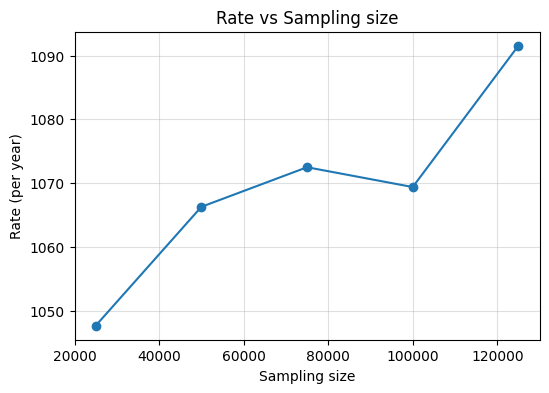

In [4]:
# getting data from json
meta_data= get_param_from_json("./ler_data/meta_unlensed_O4_spur_sub.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

### Sub+Super

In [5]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 40000)[0]
# take average 
gw_rate_unlensed1 = np.mean(meta_data['total_rate'][idx])
print('Unlensed GW Rate (per year), SNR>6 =', gw_rate_unlensed1)

Unlensed GW Rate (per year), SNR>6 = 1074.9299968980656


### Super

In [6]:
unlensed_param = get_param_from_json("./ler_data/n_unlensed_param_detectable_O4_spur_sub.json")

In [7]:
snr = unlensed_param['optimal_snr_net']
idx = snr>8.0
snr8_vs_snr6 = np.sum(idx)/len(snr)
print('Unlensed GW Rate (per year), SNR>8 =', gw_rate_unlensed1*snr8_vs_snr6) 

Unlensed GW Rate (per year), SNR>8 = 446.1204160115644


## Lensed events

In [12]:
ler.selecting_n_lensed_detectable_events(
    size=80000,
    batch_size=200000,
    snr_threshold=[6.0, 6.0],
    num_img=[1, 1],
    resume=True,
    detectability_condition='step_function',
    output_jsonfile='n_lensed_param_detectable_O4_spur_sub.json',
    meta_data_file='meta_lensed_O4_spur_sub.json',
    trim_to_size=False,
    nan_to_num=False,
);

collected number of detectable events =  60496


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.83it/s]


given detectability_condition == step_function
collected number of detectable events =  62393
total number of events =  6600000
total rate (yr^-1): 2.146793769760623


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.22it/s]


given detectability_condition == step_function
collected number of detectable events =  64339
total number of events =  6800000
total rate (yr^-1): 2.148640648619495


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.65it/s]


given detectability_condition == step_function
collected number of detectable events =  66239
total number of events =  7000000
total rate (yr^-1): 2.1488896845116505


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.65s/it]


given detectability_condition == step_function
collected number of detectable events =  68168
total number of events =  7200000
total rate (yr^-1): 2.1500395539396298


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.49it/s]


given detectability_condition == step_function
collected number of detectable events =  70020
total number of events =  7400000
total rate (yr^-1): 2.1487643026634924


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.18it/s]


given detectability_condition == step_function
collected number of detectable events =  71944
total number of events =  7600000
total rate (yr^-1): 2.14970755072251


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


given detectability_condition == step_function
collected number of detectable events =  73802
total number of events =  7800000
total rate (yr^-1): 2.1486808946203393


 30%|████████████████                                      | 59603/200000 [00:17<00:40, 3484.12it/s]


KeyboardInterrupt: 

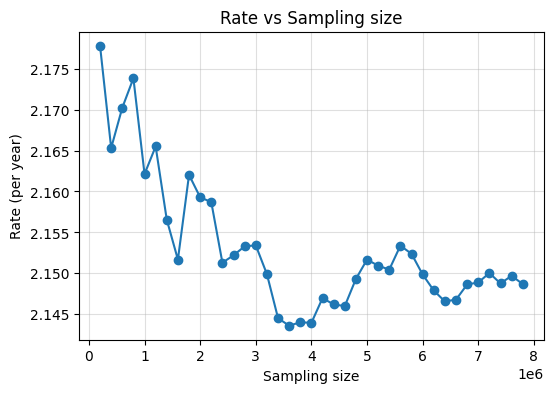

In [13]:
# getting data from json
meta_data= get_param_from_json("./ler_data/meta_lensed_O4_spur_sub.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

### Sub+Super

In [14]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 5.0e6)[0]
# take average 
gw_rate_lensed1 = np.mean(meta_data['total_rate'][idx])
print('Lensed GW Rate (per year), 2 or more images SNR>6 =', gw_rate_lensed1)

Lensed GW Rate (per year), 2 or more images SNR>6 = 2.1495015032473535


### Super

In [19]:
snr_lensed = get_param_from_json("./ler_data/n_lensed_param_detectable_O4_spur_sub.json")['optimal_snr_net']
idx = snr_lensed>8.0
idx = np.sum(idx, axis=1)>=2
snr8_vs_snr6 = np.sum(idx)/len(snr_lensed)
print('Lensed GW Rate (per year), 2 or more images SNR>8 =', gw_rate_lensed1*snr8_vs_snr6)

Lensed GW Rate (per year), 2 or more images SNR>8 = 1.003452146166514
